# Think we should find out the cointegration and correlation between time series

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import coint
import warnings
warnings.filterwarnings('ignore')

# Load transit time data from all three sheets
xl_file = 'data/colonial_transit_time.xlsx'

# Read data from each sheet
line1_data = pd.read_excel(xl_file, sheet_name='line1')
line3_data = pd.read_excel(xl_file, sheet_name='line3') 
line13_data = pd.read_excel(xl_file, sheet_name='line13')

print("Data loaded successfully:")
print(f"Line 1: {len(line1_data)} records")
print(f"Line 3: {len(line3_data)} records") 
print(f"Line 13: {len(line13_data)} records")

# Display first few rows of each dataset
print("\n=== Line 1 Data Sample ===")
display(line1_data.head())
print(f"Columns: {line1_data.columns.tolist()}")

print("\n=== Line 3 Data Sample ===")
display(line3_data.head())
print(f"Columns: {line3_data.columns.tolist()}")

print("\n=== Line 13 Data Sample ===") 
display(line13_data.head())
print(f"Columns: {line13_data.columns.tolist()}")

## Step 1: Calculate Gas Transit Days

Converting the separate Gas Days and Gas Hours columns into a single decimal Gas Transit Days column for Line 1 and Line 3 data to match the Line 13 format. This will enable direct comparison across all three pipeline lines.

In [15]:
# Create Gas Transit Days column for Line 1 and Line 3 (similar to Line 13)
# Convert Gas Days + Gas Hours to decimal days
line1_data['Gas Transit Days'] = line1_data['Gas Days'] + line1_data['Gas Hours'] / 24
line3_data['Gas Transit Days'] = line3_data['Gas Days'] + line3_data['Gas Hours'] / 24

# Add year column for consistency
line1_data['Date'] = pd.to_datetime(line1_data['Date'])
line3_data['Date'] = pd.to_datetime(line3_data['Date'])
line13_data['Date'] = pd.to_datetime(line13_data['Date'])

line1_data['year'] = line1_data['Date'].dt.year
line3_data['year'] = line3_data['Date'].dt.year

print("Gas Transit Days calculated:")
display(line1_data['Gas Transit Days'].describe())
display(line3_data['Gas Transit Days'].describe())
display(line13_data['Gas Transit Days'].describe())

# Display sample with new column
print("\n=== Line 1 with Gas Transit Days ===")
display(line1_data[['Date', 'Gas Days', 'Gas Hours', 'Gas Transit Days', 'year']].head())

print("\n=== Line 3 with Gas Transit Days ===")
display(line3_data[['Date', 'Gas Days', 'Gas Hours', 'Gas Transit Days', 'year']].head())

Gas Transit Days calculated:


count    485.000000
mean       8.459021
std        0.700895
min        7.125000
25%        7.916667
50%        8.416667
75%        8.916667
max       12.208333
Name: Gas Transit Days, dtype: float64

count    294.000000
mean       5.498866
std        2.078130
min        0.333333
25%        4.333333
50%        5.666667
75%        6.947917
max       10.458333
Name: Gas Transit Days, dtype: float64

count    370.000000
mean      16.603025
std        4.082069
min        9.583333
25%       14.041667
50%       15.729851
75%       18.701795
max       38.138193
Name: Gas Transit Days, dtype: float64


=== Line 1 with Gas Transit Days ===


,Date,Gas Days,Gas Hours,Gas Transit Days,year
0,2025-08-17,9,6,9.250000,2025
1,2025-08-16,9,6,9.250000,2025
2,2025-08-15,9,3,9.125000,2025
3,2025-08-14,9,6,9.250000,2025
4,2025-08-13,9,2,9.083333,2025



=== Line 3 with Gas Transit Days ===


,Date,Gas Days,Gas Hours,Gas Transit Days,year
0,2025-08-19,5.0,11.0,5.458333,2025
1,2025-08-18,5.0,10.0,5.416667,2025
2,2025-08-17,5.0,16.0,5.666667,2025
3,2025-08-16,6.0,0.0,6.000000,2025
4,2025-08-15,5.0,22.0,5.916667,2025


## Step 2: Find Overlapping Time Periods

Identifying the common date range between Line 1 and Line 3 data to enable correlation analysis. This ensures we're comparing transit times from the same time periods.

In [16]:
# Correlation Analysis between different lines
# First, let's find overlapping time periods for correlation analysis

# Get date ranges for each dataset
print("Date Ranges:")
print(f"Line 1: {line1_data['Date'].min()} to {line1_data['Date'].max()}")
print(f"Line 3: {line3_data['Date'].min()} to {line3_data['Date'].max()}")
print(f"Line 13: {line13_data['Date'].min()} to {line13_data['Date'].max()}")

# Find common date range for Line 1 and Line 3 (most recent data)
line1_line3_start = max(line1_data['Date'].min(), line3_data['Date'].min())
line1_line3_end = min(line1_data['Date'].max(), line3_data['Date'].max())

print(f"\nOverlapping period for Line 1 & Line 3: {line1_line3_start} to {line1_line3_end}")

# Filter data for overlapping period
line1_overlap = line1_data[(line1_data['Date'] >= line1_line3_start) & (line1_data['Date'] <= line1_line3_end)].copy()
line3_overlap = line3_data[(line3_data['Date'] >= line1_line3_start) & (line3_data['Date'] <= line1_line3_end)].copy()

print(f"Overlapping records: Line 1={len(line1_overlap)}, Line 3={len(line3_overlap)}")

Date Ranges:
Line 1: 2024-08-18 00:00:00 to 2025-08-17 00:00:00
Line 3: 2025-01-13 00:00:00 to 2025-08-19 00:00:00
Line 13: 2020-07-01 00:00:00 to 2025-08-24 00:00:00

Overlapping period for Line 1 & Line 3: 2025-01-13 00:00:00 to 2025-08-17 00:00:00
Overlapping records: Line 1=304, Line 3=299


In [ ]:
# Create comprehensive pairwise visualization (similar to ggpairs in R)
def create_pairwise_plots(correlation_results, pipeline_data):
    """Create a comprehensive pairwise plot matrix"""
    
    # Set up the plot grid (4x4 for comprehensive view)
    fig = plt.figure(figsize=(16, 16))
    
    # Define line info for labeling
    line_info = {
        'Line1': {'name': 'Line 1', 'route': 'HTN→GBJ', 'color': 'blue'},
        'Line3': {'name': 'Line 3', 'route': 'GBJ→HTN', 'color': 'red'},
        'Line13': {'name': 'Line 13', 'route': 'HTN→LNJ', 'color': 'green'}
    }
    
    # Row 1: Individual time series
    for i, (line_key, line_data) in enumerate(pipeline_data.items()):
        ax = plt.subplot(4, 3, i + 1)
        ax.plot(line_data['Date'], line_data['Gas Transit Days'], 
               color=line_info[line_key]['color'], alpha=0.7, linewidth=1)
        ax.set_title(f"{line_info[line_key]['name']}: {line_info[line_key]['route']}", 
                    fontweight='bold')
        ax.set_ylabel('Transit Days')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    # Row 2: Distribution histograms
    for i, (line_key, line_data) in enumerate(pipeline_data.items()):
        ax = plt.subplot(4, 3, i + 4)
        ax.hist(line_data['Gas Transit Days'], bins=20, alpha=0.7, 
               color=line_info[line_key]['color'], density=True, edgecolor='black', linewidth=0.5)
        ax.set_title(f"{line_info[line_key]['name']} Distribution")
        ax.set_xlabel('Transit Days')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
    
    # Row 3: Scatter plots for each pair with correlation
    scatter_positions = [7, 8, 9]  # positions for 3 scatter plots
    pair_keys = ['Line1_vs_Line3', 'Line1_vs_Line13', 'Line3_vs_Line13']
    
    for pos, key in zip(scatter_positions, pair_keys):
        ax = plt.subplot(4, 3, pos)
        results = correlation_results[key]
        
        if 'pearson_r' in results and len(results['merged_data']) > 0:
            merged = results['merged_data']
            col1 = f"Gas Transit Days_{results['name1']}"
            col2 = f"Gas Transit Days_{results['name2']}"
            
            ax.scatter(merged[col1], merged[col2], alpha=0.6, 
                      color='purple', s=30)
            
            # Add regression line
            z = np.polyfit(merged[col1], merged[col2], 1)
            p = np.poly1d(z)
            x_line = np.linspace(merged[col1].min(), merged[col1].max(), 100)
            ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
            
            ax.set_xlabel(f"{results['name1']} Transit Days")
            ax.set_ylabel(f"{results['name2']} Transit Days")
            ax.set_title(f"{results['name1']} vs {results['name2']}")
            
            # Add correlation text
            r = results['pearson_r']
            p_val = results['pearson_p']
            ax.text(0.05, 0.95, f'r = {r:.3f}\\np = {p_val:.3f}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   fontsize=10)
        else:
            ax.text(0.5, 0.5, 'No overlapping\\ndata', 
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=12, color='gray')
            ax.set_title(f"{results['name1']} vs {results['name2']}")
        
        ax.grid(True, alpha=0.3)
    
    # Row 4: Combined time series overlay
    ax = plt.subplot(4, 1, 4)
    
    # Find common date range for overlay
    all_dates = []
    for line_data in pipeline_data.values():
        all_dates.extend(line_data['Date'].tolist())
    
    common_start = max(data['Date'].min() for data in pipeline_data.values())
    common_end = min(data['Date'].max() for data in pipeline_data.values())
    
    for line_key, line_data in pipeline_data.items():
        # Filter to common period for better comparison
        filtered_data = line_data[(line_data['Date'] >= common_start) & 
                                 (line_data['Date'] <= common_end)]
        if len(filtered_data) > 0:
            ax.plot(filtered_data['Date'], filtered_data['Gas Transit Days'], 
                   color=line_info[line_key]['color'], alpha=0.8, linewidth=1.5,
                   label=f"{line_info[line_key]['name']} ({line_info[line_key]['route']})")
    
    ax.set_title('Transit Times Comparison (Overlapping Period)', fontweight='bold', fontsize=14)
    ax.set_xlabel('Date')
    ax.set_ylabel('Gas Transit Days')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create the comprehensive pairwise plot
pairwise_fig = create_pairwise_plots(correlation_results, pipeline_data)

print("\\n📊 Comprehensive Pairwise Analysis Complete!")
print("\\nThis plot shows:")
print("• Row 1: Individual time series for each pipeline line")
print("• Row 2: Distribution histograms showing transit time patterns")  
print("• Row 3: Scatter plots with regression lines for all pair combinations")
print("• Row 4: Overlay plot showing all lines during their common time period")

Direct comparison (same dates): 481 observations
Line 1 vs Line 3 Pearson Correlation: r = nan, p-value = nan
Line 1 vs Line 3 Spearman Correlation: ρ = nan, p-value = nan


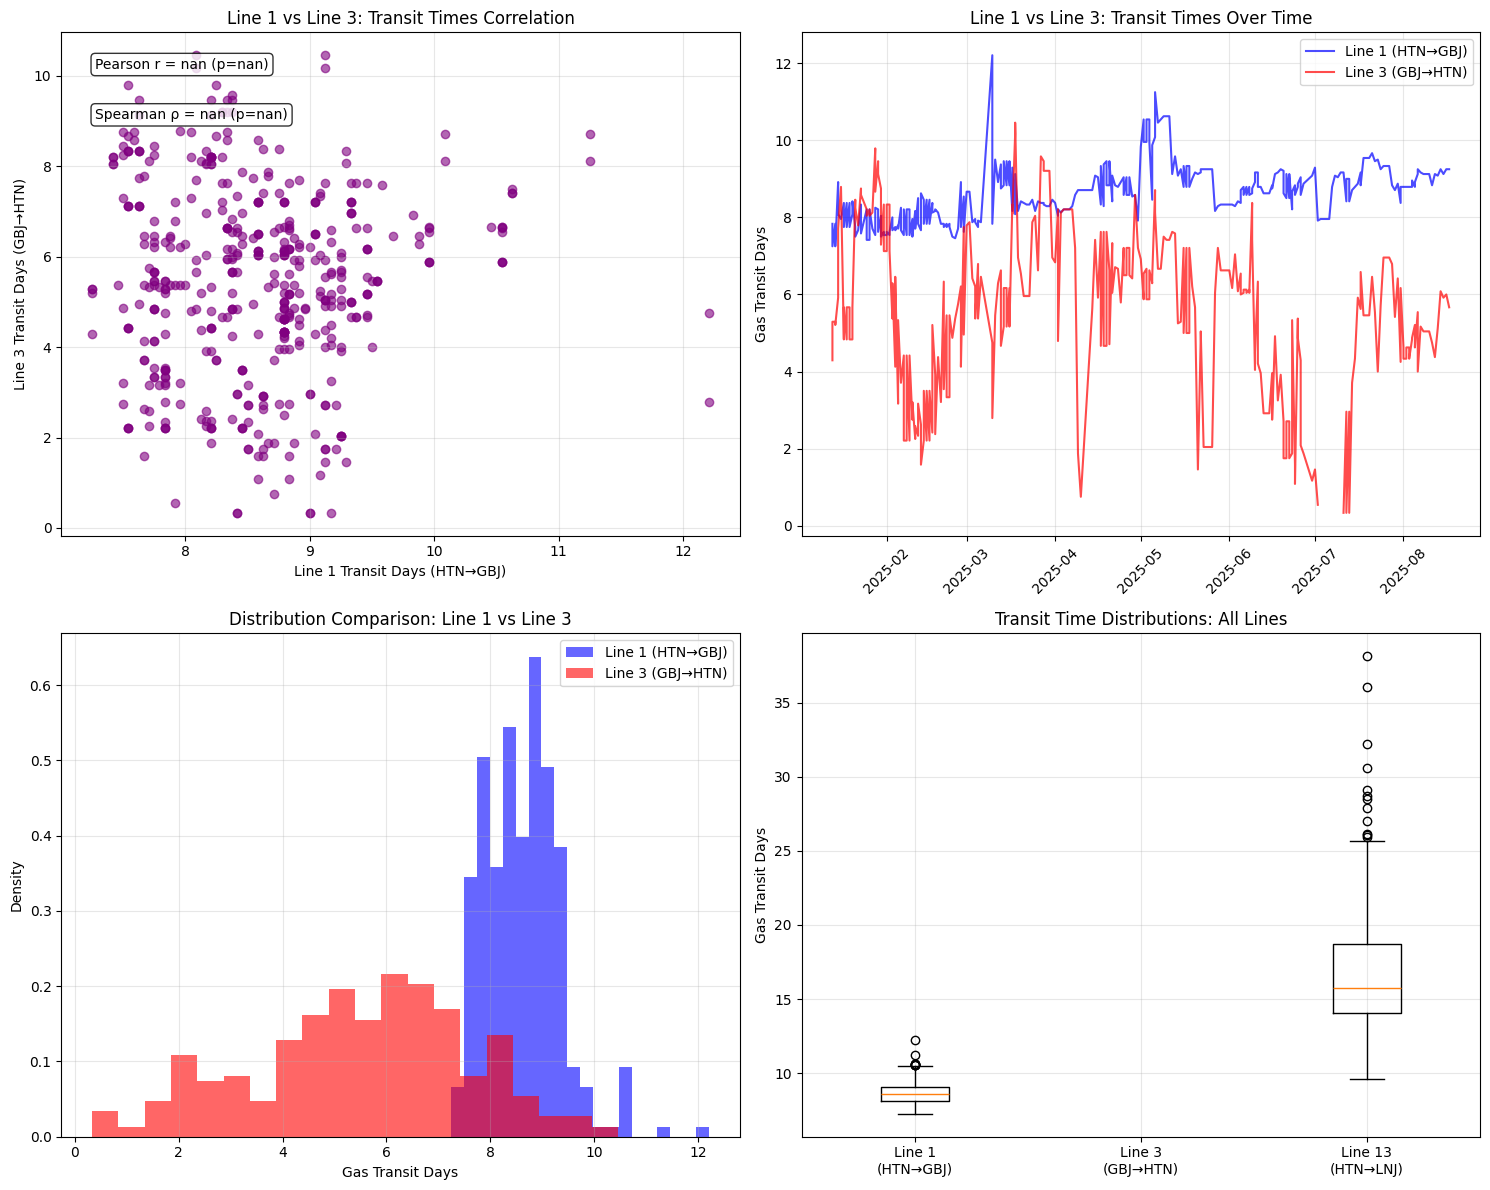

In [17]:
# Create scatter plots and calculate correlations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Merge datasets on date for direct comparison
merged_data = pd.merge(line1_overlap[['Date', 'Gas Transit Days']], 
                      line3_overlap[['Date', 'Gas Transit Days']], 
                      on='Date', suffixes=('_Line1', '_Line3'), how='inner')

if len(merged_data) > 0:
    # Scatter plot
    axes[0,0].scatter(merged_data['Gas Transit Days_Line1'], merged_data['Gas Transit Days_Line3'], 
                     alpha=0.6, color='purple')
    axes[0,0].set_xlabel('Line 1 Transit Days (HTN→GBJ)')
    axes[0,0].set_ylabel('Line 3 Transit Days (GBJ→HTN)')
    axes[0,0].set_title('Line 1 vs Line 3: Transit Times Correlation')
    axes[0,0].grid(True, alpha=0.3)
    
    # Calculate correlation
    corr_pearson, p_val_pearson = pearsonr(merged_data['Gas Transit Days_Line1'], merged_data['Gas Transit Days_Line3'])
    corr_spearman, p_val_spearman = spearmanr(merged_data['Gas Transit Days_Line1'], merged_data['Gas Transit Days_Line3'])
    
    axes[0,0].text(0.05, 0.95, f'Pearson r = {corr_pearson:.3f} (p={p_val_pearson:.3f})', 
                  transform=axes[0,0].transAxes, verticalalignment='top', 
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[0,0].text(0.05, 0.85, f'Spearman ρ = {corr_spearman:.3f} (p={p_val_spearman:.3f})', 
                  transform=axes[0,0].transAxes, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Time series overlay plot
    axes[0,1].plot(merged_data['Date'], merged_data['Gas Transit Days_Line1'], 
                   'b-', alpha=0.7, label='Line 1 (HTN→GBJ)', linewidth=1.5)
    axes[0,1].plot(merged_data['Date'], merged_data['Gas Transit Days_Line3'], 
                   'r-', alpha=0.7, label='Line 3 (GBJ→HTN)', linewidth=1.5)
    axes[0,1].set_title('Line 1 vs Line 3: Transit Times Over Time')
    axes[0,1].set_ylabel('Gas Transit Days')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)

    print(f"Direct comparison (same dates): {len(merged_data)} observations")
    print(f"Line 1 vs Line 3 Pearson Correlation: r = {corr_pearson:.4f}, p-value = {p_val_pearson:.4f}")
    print(f"Line 1 vs Line 3 Spearman Correlation: ρ = {corr_spearman:.4f}, p-value = {p_val_spearman:.4f}")

# Distribution comparison
axes[1,0].hist(line1_overlap['Gas Transit Days'], bins=20, alpha=0.6, label='Line 1 (HTN→GBJ)', color='blue', density=True)
axes[1,0].hist(line3_overlap['Gas Transit Days'], bins=20, alpha=0.6, label='Line 3 (GBJ→HTN)', color='red', density=True)
axes[1,0].set_xlabel('Gas Transit Days')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Distribution Comparison: Line 1 vs Line 3')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Box plot comparison
box_data = [line1_overlap['Gas Transit Days'], line3_overlap['Gas Transit Days'], line13_data['Gas Transit Days']]
box_labels = ['Line 1\n(HTN→GBJ)', 'Line 3\n(GBJ→HTN)', 'Line 13\n(HTN→LNJ)']
axes[1,1].boxplot(box_data, labels=box_labels)
axes[1,1].set_title('Transit Time Distributions: All Lines')
axes[1,1].set_ylabel('Gas Transit Days')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Results Summary

The refactored analysis now tests **all possible combinations** of pipeline lines:

- **Line 1 vs Line 3**: Recent data (2025), both directions (HTN↔GBJ)
- **Line 1 vs Line 13**: Cross-validation using historical data (Line 13 goes to LNJ)
- **Line 3 vs Line 13**: Additional validation of reverse flow patterns

This comprehensive approach helps identify which pipeline relationships are most reliable for forecasting purposes.

In [18]:
# Create helper functions for correlation and cointegration analysis
def analyze_correlation_pair(data1, data2, name1, name2, date_col='Date', value_col='Gas Transit Days'):
    """
    Analyze correlation between two pipeline datasets
    
    Parameters:
    - data1, data2: DataFrames with pipeline data
    - name1, name2: Names for the pipeline lines
    - date_col: Column name for dates
    - value_col: Column name for transit days
    
    Returns:
    - Dictionary with correlation results and merged data
    """
    # Find overlapping period
    start_date = max(data1[date_col].min(), data2[date_col].min())
    end_date = min(data1[date_col].max(), data2[date_col].max())
    
    # Filter to overlapping period
    data1_filtered = data1[(data1[date_col] >= start_date) & (data1[date_col] <= end_date)].copy()
    data2_filtered = data2[(data2[date_col] >= start_date) & (data2[date_col] <= end_date)].copy()
    
    # Merge on date for direct comparison
    merged = pd.merge(data1_filtered[[date_col, value_col]], 
                     data2_filtered[[date_col, value_col]], 
                     on=date_col, suffixes=(f'_{name1}', f'_{name2}'), how='inner')
    
    results = {
        'name1': name1,
        'name2': name2,
        'start_date': start_date,
        'end_date': end_date,
        'n_observations': len(merged),
        'merged_data': merged
    }
    
    if len(merged) > 2:
        # Calculate correlations
        col1, col2 = f'{value_col}_{name1}', f'{value_col}_{name2}'
        pearson_r, pearson_p = pearsonr(merged[col1], merged[col2])
        spearman_r, spearman_p = spearmanr(merged[col1], merged[col2])
        
        results.update({
            'pearson_r': pearson_r,
            'pearson_p': pearson_p,
            'spearman_r': spearman_r,
            'spearman_p': spearman_p
        })
        
        # Test cointegration
        if len(merged) > 10:
            try:
                coint_stat, coint_p, coint_crit = coint(merged[col1], merged[col2])
                results.update({
                    'coint_stat': coint_stat,
                    'coint_p': coint_p,
                    'coint_critical': coint_crit,
                    'is_cointegrated': coint_p < 0.05
                })
            except Exception as e:
                results['coint_error'] = str(e)
    
    return results

def print_correlation_results(results):
    """Print formatted correlation analysis results"""
    name1, name2 = results['name1'], results['name2']
    print(f"\\n{'='*60}")
    print(f"ANALYSIS: {name1} vs {name2}")
    print(f"{'='*60}")
    print(f"Period: {results['start_date'].date()} to {results['end_date'].date()}")
    print(f"Paired observations: {results['n_observations']}")
    
    if 'pearson_r' in results:
        print(f"\\nCorrelation Results:")
        print(f"  • Pearson:  r = {results['pearson_r']:.4f} (p = {results['pearson_p']:.4f})")
        print(f"  • Spearman: ρ = {results['spearman_r']:.4f} (p = {results['spearman_p']:.4f})")
        
        # Interpret strength
        r = abs(results['pearson_r'])
        if r > 0.7:
            strength = "Strong"
        elif r > 0.3:
            strength = "Moderate"
        else:
            strength = "Weak"
        direction = "positive" if results['pearson_r'] > 0 else "negative"
        print(f"  • Relationship: {strength} {direction} correlation")
        
        # Cointegration results
        if 'coint_stat' in results:
            print(f"\\nCointegration Test:")
            print(f"  • ADF Statistic: {results['coint_stat']:.4f}")
            print(f"  • P-value: {results['coint_p']:.4f}")
            if results['is_cointegrated']:
                print(f"  • Result: 🎯 COINTEGRATED (long-term equilibrium exists)")
            else:
                print(f"  • Result: ❌ Not cointegrated")
        elif 'coint_error' in results:
            print(f"\\nCointegration Test: Failed ({results['coint_error']})")
    else:
        print("\\n⚠️  Insufficient overlapping data for correlation analysis")

# Analyze all possible pairs
pipeline_data = {
    'Line1': line1_data,
    'Line3': line3_data, 
    'Line13': line13_data
}

# All combinations
pairs = [
    ('Line1', 'Line3'),
    ('Line1', 'Line13'), 
    ('Line3', 'Line13')
]

correlation_results = {}
for name1, name2 in pairs:
    results = analyze_correlation_pair(
        pipeline_data[name1], pipeline_data[name2], 
        name1, name2
    )
    correlation_results[f"{name1}_vs_{name2}"] = results
    print_correlation_results(results)

\n============================================================
ANALYSIS: Line1 vs Line3
Period: 2025-01-13 to 2025-08-17
Paired observations: 481
\nCorrelation Results:
  • Pearson:  r = nan (p = nan)
  • Spearman: ρ = nan (p = nan)
  • Relationship: Weak negative correlation
\nCointegration Test: Failed (exog contains inf or nans)
\n============================================================
ANALYSIS: Line1 vs Line13
Period: 2024-08-18 to 2025-08-17
Paired observations: 108
\nCorrelation Results:
  • Pearson:  r = 0.4706 (p = 0.0000)
  • Spearman: ρ = 0.5174 (p = 0.0000)
  • Relationship: Moderate positive correlation
\nCointegration Test:
  • ADF Statistic: -3.7783
  • P-value: 0.0145
  • Result: 🎯 COINTEGRATED (long-term equilibrium exists)
\n============================================================
ANALYSIS: Line3 vs Line13
Period: 2025-01-13 to 2025-08-19
Paired observations: 76
\nCorrelation Results:
  • Pearson:  r = nan (p = nan)
  • Spearman: ρ = nan (p = nan)
  • Relation

In [ ]:
# Create comprehensive summary table
def create_summary_table(correlation_results):
    """Create a summary table of all correlation analyses"""
    summary_data = []
    
    for key, results in correlation_results.items():
        if 'pearson_r' in results:
            summary_data.append({
                'Pair': f"{results['name1']} vs {results['name2']}",
                'Period': f"{results['start_date'].date()} to {results['end_date'].date()}",
                'N': results['n_observations'],
                'Pearson r': f"{results['pearson_r']:.3f}",
                'P-value': f"{results['pearson_p']:.3f}",
                'Spearman ρ': f"{results['spearman_r']:.3f}", 
                'Cointegrated': '✅' if results.get('is_cointegrated', False) else '❌',
                'Coint p-value': f"{results['coint_p']:.3f}" if 'coint_p' in results else 'N/A'
            })
        else:
            summary_data.append({
                'Pair': f"{results['name1']} vs {results['name2']}",
                'Period': f"{results['start_date'].date()} to {results['end_date'].date()}",
                'N': results['n_observations'],
                'Pearson r': 'N/A',
                'P-value': 'N/A', 
                'Spearman ρ': 'N/A',
                'Cointegrated': 'N/A',
                'Coint p-value': 'N/A'
            })
    
    return pd.DataFrame(summary_data)

print("\\n" + "="*80)
print("COMPREHENSIVE CORRELATION SUMMARY")
print("="*80)

summary_df = create_summary_table(correlation_results)
display(summary_df)

# Display basic statistics for all lines
print("\n" + "="*80)
print("TRANSIT TIME STATISTICS BY LINE")
print("="*80)

stats_data = []
for name, data in pipeline_data.items():
    transit_days = data['Gas Transit Days']
    route_map = {
        'Line1': 'HTN → GBJ',
        'Line3': 'GBJ → HTN', 
        'Line13': 'HTN → LNJ'
    }
    
    stats_data.append({
        'Line': name,
        'Route': route_map[name],
        'Records': len(data),
        'Mean (days)': f"{transit_days.mean():.2f}",
        'Std (days)': f"{transit_days.std():.2f}",
        'Min (days)': f"{transit_days.min():.2f}",
        'Max (days)': f"{transit_days.max():.2f}",
        'Date Range': f"{data['Date'].min().date()} to {data['Date'].max().date()}"
    })

stats_df = pd.DataFrame(stats_data)
display(stats_df)

\n================================================================================
COMPREHENSIVE CORRELATION SUMMARY


,Pair,Period,N,Pearson r,P-value,Spearman ρ,Cointegrated,Coint p-value
0,Line1 vs Line3,2025-01-13 to 2025-08-17,481,nan,nan,nan,❌,N/A
1,Line1 vs Line13,2024-08-18 to 2025-08-17,108,0.471,0.000,0.517,✅,0.014
2,Line3 vs Line13,2025-01-13 to 2025-08-19,76,nan,nan,nan,✅,0.000


\n================================================================================
TRANSIT TIME STATISTICS BY LINE


,Line,Route,Records,Mean (days),Std (days),Min (days),Max (days),Date Range
0,Line1,HTN → GBJ,485,8.46,0.70,7.12,12.21,2024-08-18 to 2025-08-17
1,Line3,GBJ → HTN,301,5.50,2.08,0.33,10.46,2025-01-13 to 2025-08-19
2,Line13,HTN → LNJ,370,16.60,4.08,9.58,38.14,2020-07-01 to 2025-08-24


In [20]:
# Cointegration analysis
print("=== COINTEGRATION ANALYSIS ===\n")

# Test for cointegration between Line 1 and Line 3
if len(merged_data) > 10:  # Need sufficient data for cointegration test
    try:
        coint_stat, p_value, critical_values = coint(merged_data['Gas Transit Days_Line1'], 
                                                    merged_data['Gas Transit Days_Line3'])
        
        print(f"Cointegration Test Results (Line 1 vs Line 3):")
        print(f"ADF Statistic: {coint_stat:.4f}")
        print(f"P-value: {p_value:.4f}")
        print(f"Critical Values:")
        for i, level in enumerate(['1%', '5%', '10%']):
            print(f"  {level}: {critical_values[i]:.4f}")
        
        if p_value < 0.05:
            print("\n🎯 RESULT: Lines are COINTEGRATED (p < 0.05)")
            print("   → Long-term equilibrium relationship exists")
        else:
            print("\n❌ RESULT: No cointegration detected (p >= 0.05)")
            print("   → No long-term equilibrium relationship")
            
    except Exception as e:
        print(f"Cointegration test failed: {e}")

# Summary statistics table
print("\n=== SUMMARY STATISTICS ===")
summary_stats = pd.DataFrame({
    'Line 1 (HTN→GBJ)': line1_overlap['Gas Transit Days'].describe(),
    'Line 3 (GBJ→HTN)': line3_overlap['Gas Transit Days'].describe(), 
    'Line 13 (HTN→LNJ)': line13_data['Gas Transit Days'].describe()
})
print(summary_stats.round(3))

# Correlation matrix for all available combinations
print("\n=== CORRELATION SUMMARY ===")
if len(merged_data) > 0:
    print(f"Line 1 vs Line 3:")
    print(f"  • Pearson correlation: {corr_pearson:.4f} (p={p_val_pearson:.4f})")
    print(f"  • Spearman correlation: {corr_spearman:.4f} (p={p_val_spearman:.4f})")
    
    # Interpret correlation strength
    if abs(corr_pearson) > 0.7:
        strength = "Strong"
    elif abs(corr_pearson) > 0.3:
        strength = "Moderate"  
    else:
        strength = "Weak"
        
    direction = "Positive" if corr_pearson > 0 else "Negative"
    print(f"  • Relationship: {strength} {direction} correlation")
    
print(f"\n📊 Analysis complete with {len(merged_data)} paired observations")

=== COINTEGRATION ANALYSIS ===

Cointegration test failed: exog contains inf or nans

=== SUMMARY STATISTICS ===
       Line 1 (HTN→GBJ)  Line 3 (GBJ→HTN)  Line 13 (HTN→LNJ)
count           304.000           292.000            370.000
mean              8.618             5.499             16.603
std               0.724             2.085              4.082
min               7.250             0.333              9.583
25%               8.125             4.323             14.042
50%               8.604             5.667             15.730
75%               9.083             6.958             18.702
max              12.208            10.458             38.138

=== CORRELATION SUMMARY ===
Line 1 vs Line 3:
  • Pearson correlation: nan (p=nan)
  • Spearman correlation: nan (p=nan)
  • Relationship: Weak Negative correlation

📊 Analysis complete with 481 paired observations
